In [1]:
# imports: 
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
torch.manual_seed(0);

In [2]:
train_data = pd.read_csv('energy_train.csv')
test_data = pd.read_csv('energy_test.csv')

In [3]:
x_train = torch.tensor(train_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_train = torch.tensor(train_data[['W']].values).float()
x_test = torch.tensor(test_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_test = torch.tensor(test_data[['W']].values).float()

In [4]:
class InvariantLayer(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):      
        return self.func(x)

def invariations(x):
    x = x.view(-1, 3, 3)
    det = torch.det(x)
    det = det.view(-1, 1)
    x_t = x.transpose(1, 2)
    mult = torch.bmm(x_t, x)
    trace = torch.diagonal(mult, dim1=1, dim2=2).sum(1)
    trace = trace.view(-1, 1)
    output = torch.cat((trace, det), 1) 
    return output

In [5]:
def non_negative_weights_init(module):
    if isinstance(module, nn.Linear):
        #nn.init.normal_(module.weight, mean=0, std=0.1)
        #nn.init.constant_(module.bias, 0)

        # Ensure non-negative weights
        module.weight.data.clamp_(min=0)
    elif isinstance(module, nn.ReLU) or isinstance(module, nn.ELU):
        # Ensure non-negative parameters for ReLU and ELU
        module.inplace = True

In [6]:
icnn_nn = nn.Sequential(
    InvariantLayer(invariations),
    nn.Linear(2,6),
    nn.ReLU(),
    nn.Linear(6,12),
    nn.ReLU(),
    nn.Linear(12,20),
    nn.ELU(),
    nn.Linear(20,15),
    nn.Sigmoid(),
    nn.Linear(15,10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.ReLU(),
    nn.Linear(5,1)
)

icnn_nn.apply(non_negative_weights_init)

# Print the ICNN architecture
print('Input-Convex Neural Network (ICNN):\n\n', icnn_nn)

# Print parameters to confirm non-negativity
for name, param in icnn_nn.named_parameters():
    if 'weight' in name:
        print(name, param.min().item(), param.max().item())

Input-Convex Neural Network (ICNN):

 Sequential(
  (0): InvariantLayer()
  (1): Linear(in_features=2, out_features=6, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=6, out_features=12, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=12, out_features=20, bias=True)
  (6): ELU(alpha=1.0, inplace=True)
  (7): Linear(in_features=20, out_features=15, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=15, out_features=10, bias=True)
  (10): ReLU(inplace=True)
  (11): Linear(in_features=10, out_features=5, bias=True)
  (12): ReLU(inplace=True)
  (13): Linear(in_features=5, out_features=1, bias=True)
)
1.weight 0.0 0.13836100697517395
3.weight 0.0 0.1963215470314026
5.weight 0.0 0.2789911925792694
7.weight 0.0 0.30229321122169495
9.weight 0.0 0.2033979892730713
11.weight 0.0 0.2090688943862915
13.weight 0.0 0.0893988311290741


In [7]:
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.01

# Instantiate the custom neural network
#fwd_nn = CustomNN()

# Optimizer: use Adam
optimizer = torch.optim.Adam(icnn_nn.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# number of steps, the proper term is 'EPOCH'
num_epochs = 1000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = icnn_nn(x_train)
    
    # Compute the loss.
    train_loss = loss_function(y_train_pred, y_train)
    
    # Store the loss in a list
    train_loss_history.append(train_loss.item())
    
    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad():
        # Make your predictions
        y_test_pred = icnn_nn(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        # Store the loss in a list
        test_loss_history.append(test_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')

Epoch [1/1000]
Epoch [101/1000]
Epoch [201/1000]
Epoch [301/1000]
Epoch [401/1000]
Epoch [501/1000]
Epoch [601/1000]
Epoch [701/1000]
Epoch [801/1000]
Epoch [901/1000]


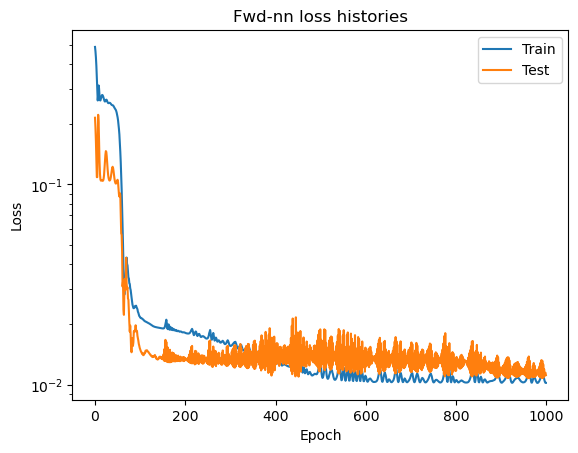

In [8]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.title('Fwd-nn loss histories');

In [9]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_strainenergy(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('W: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    fig.tight_layout()

def plotR2_design(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    labels = ['rho','theta-1','theta-2','theta-3']
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach(),c='green')
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('{},  R2={}'.format(labels[index],R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(2, 2, i+1)
        helper(ax,i)
    fig.tight_layout()

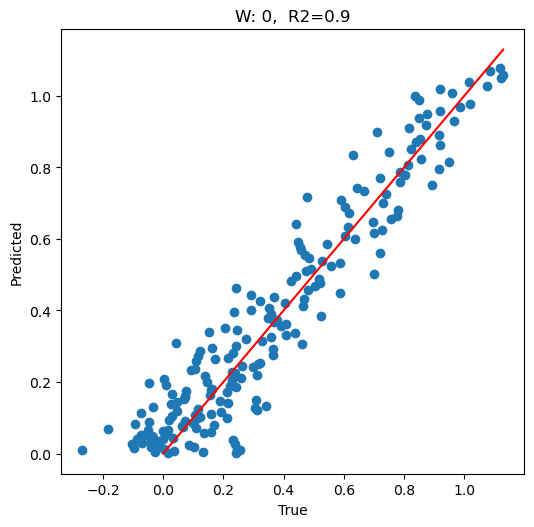

In [10]:
# Make prediction on test set
with torch.no_grad():
    y_tset_pred = icnn_nn(x_test)

# Visualize accuracy
plotR2_strainenergy(y_test, y_test_pred)